In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jlinops

In [2]:
def rand_sparse_vector(n=50, num_nsparse=10, sparse_low=1e-4, sparse_high=1e-3, nsparse_low=1e-1, nsparse_high=1e1):
    """
    Generates a random vector of length n, where num_nsparse components are `non-sparse`. 
    The `sparse` and `non-sparse` components are drawn from uniform distributions as specified.
    """
    assert num_nsparse < n, "num_nsparse must be less than n."
    result = np.random.uniform(low=sparse_low, high=sparse_high, size=n)
    nsparse_idxs = np.random.choice( [i for i in range(n)], size=num_nsparse, replace=False )
    result[nsparse_idxs] = np.random.uniform(low=nsparse_low, high=nsparse_high, size=num_nsparse)
    return result

# Blurring

In [276]:
n = 100
num_nsparse = 1
np.random.seed(0)

A = jlinops.Gaussian1DBlurOperator(n, blur_sigma=4.0, mode="constant")
Amat = jlinops.black_box_to_dense(A)
R, W = jlinops.first_order_derivative_1d(n, boundary="zero")
R = jlinops.MatrixLinearOperator(R)
Rmat = R.A.toarray()
Rinv = jlinops.MatrixLinearOperator(np.linalg.inv(R.A.toarray()))
#D = jlinops.DiagonalOperator( np.random.uniform(low=1e-5, high=1e1, size=R.shape[0]) )
theta = rand_sparse_vector(n=R.shape[0], num_nsparse=num_nsparse)
#theta = np.ones(R.shape[0])
D = jlinops.DiagonalOperator( 1.0/theta ) 
Q = (A.T @ A) + ( R.T @ D @ R )
Qmat = (Amat.T @ Amat) + (Rmat.T @ np.diag(1.0/theta) @ Rmat)
Qprior = R.T @ D @ R 

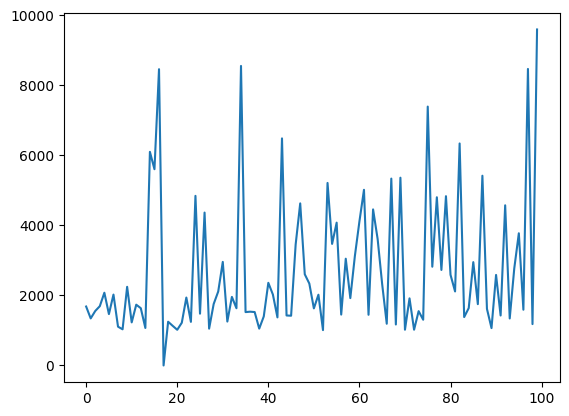

In [277]:
plt.plot(D.diagonal)
plt.show()

In [278]:
eigvals = np.linalg.eigvals(Qmat)
largest_eigval = np.amax(eigvals)
print(largest_eigval)
smallest_eigval = np.amin(eigvals)
print(smallest_eigval)
condition_number = largest_eigval / smallest_eigval
print(f"Posterior precision condition number: {condition_number}")

22726.913245343334
0.7487148350877313
Posterior precision condition number: 30354.56515654627


In [279]:
# largest_eigval, _ = jlinops.eigsh(Qprior, k=1, which="LM")
# print(largest_eigval)
# smallest_eigval, _ = jlinops.eigsh(Qprior, k=1, which="SM")
# print(smallest_eigval)
# qprior_condition_number = largest_eigval / smallest_eigval
# print(f"Prior precision condition number: {qprior_condition_number}")

In [280]:
# Build the priorconditioned matrix
#Rtilde_inv = Rinv @ jlinops.DiagonalOperator( np.sqrt(theta) )
#H = jlinops.IdentityOperator( (R.shape[0], R.shape[0]) ) +  ( Rtilde_inv.T @ ( A.T @ (A @ Rtilde_inv  ) ) )

Amat = jlinops.black_box_to_dense(A)
H = np.eye(n) + np.diag( np.sqrt(theta)) @ ( (Rinv.A.T @ Amat.T @ Amat @ Rinv.A) @ np.diag( np.sqrt(theta)) )
eigvals = np.linalg.eigvals(H)

In [281]:
largest_eigval = np.real(np.amax(eigvals))
print(largest_eigval)
smallest_eigval = np.real(np.amin(eigvals))
print(smallest_eigval)
h_condition_number = np.real(largest_eigval / smallest_eigval)
print(f"Whitened posterior precision condition number: {h_condition_number}")

26.273000073534206
0.9999999999999988
Whitened posterior precision condition number: 26.273000073534238


In [282]:
print(f"Original condition number: {condition_number}")
print(f"Whitened condition number: {h_condition_number}")

Original condition number: 30354.56515654627
Whitened condition number: 26.273000073534238


In [283]:
print(condition_number/h_condition_number)

1155.3520751946232


# Undersampling?

In [284]:
n = 100
p_observed = 0.2
mask = np.random.choice([0,1], p=[1-p_observed, p_observed], size=n)
A = jlinops.Subsampling1DOperator(mask)

In [285]:
n = 100
num_nsparse = 10
np.random.seed(0)

A = jlinops.Gaussian1DBlurOperator(n, blur_sigma=4.0, mode="constant")
R, W = jlinops.first_order_derivative_1d(n, boundary="zero")
R = jlinops.MatrixLinearOperator(R)
Rinv = jlinops.MatrixLinearOperator(np.linalg.inv(R.A.toarray()))
#D = jlinops.DiagonalOperator( np.random.uniform(low=1e-5, high=1e1, size=R.shape[0]) )
theta = rand_sparse_vector(n=R.shape[0], num_nsparse=num_nsparse)
#theta = np.ones(R.shape[0])
D = jlinops.DiagonalOperator( 1.0/theta ) 
Q = (A.T @ A) + ( R.T @ D @ R )
Qprior = R.T @ D @ R 

In [286]:
largest_eigval, _ = jlinops.eigsh(Q, k=1, which="LM")
print(largest_eigval)
smallest_eigval, _ = jlinops.eigsh(Q, k=1, which="SM")
print(smallest_eigval)
condition_number = largest_eigval / smallest_eigval
print(f"Posterior precision condition number: {condition_number}")

[22726.91324534]
[0.12915909]
Posterior precision condition number: [175960.62123856]


In [287]:
largest_eigval, _ = jlinops.eigsh(Qprior, k=1, which="LM")
print(largest_eigval)
smallest_eigval, _ = jlinops.eigsh(Qprior, k=1, which="SM")
print(smallest_eigval)
qprior_condition_number = largest_eigval / smallest_eigval
print(f"Prior precision condition number: {qprior_condition_number}")

[22726.91305734]
[0.00059444]
Prior precision condition number: [38232755.34870777]


In [288]:
# Build the priorconditioned matrix
Rtilde_inv = Rinv @ jlinops.DiagonalOperator( np.sqrt(theta) )
H = jlinops.IdentityOperator( (R.shape[0], R.shape[0]) ) +  ( Rtilde_inv.T @ ( A.T @ (A @ Rtilde_inv  ) ) )

In [196]:
largest_eigval, _ = jlinops.eigsh(H, k=1, which="LM")
print(largest_eigval)
smallest_eigval, _ = jlinops.eigsh(H, k=1, which="SM", maxiter=1000)
print(smallest_eigval)
h_condition_number = largest_eigval / smallest_eigval
print(f"Whitened posterior precision condition number: {h_condition_number}")

[1585.37890334]


ArpackNoConvergence: ARPACK error -1: No convergence (1001 iterations, 0/1 eigenvectors converged)

In [186]:
P = jlinops.black_box_to_dense(A)

In [187]:
Z = np.diag( np.sqrt(theta)) @ ( (Rinv.A.T @ P.T @ P @ Rinv.A) @ np.diag( np.sqrt(theta)) )

/Users/jonathanlindbloom/opt/miniconda3/envs/jlinops/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/jonathanlindbloom/opt/miniconda3/envs/jlinops/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[]

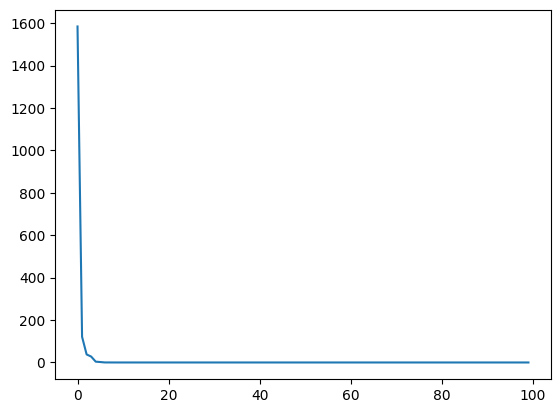

In [188]:
plt.plot(np.linalg.eigvals(Z))
plt.plot()

In [189]:
Y = Z + np.eye(n)

[]

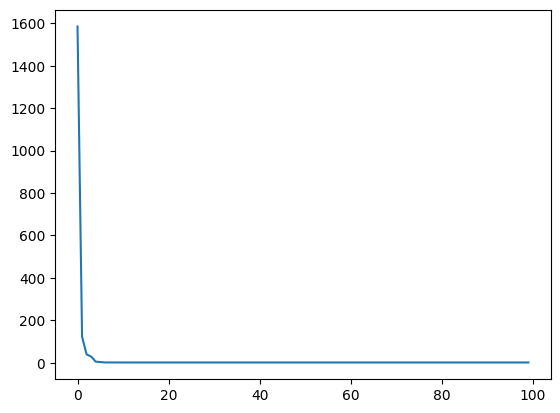

In [190]:
plt.plot(np.linalg.eigvals(Y))
plt.plot()

In [191]:
np.amin(np.linalg.eigvals(Y))

1.0000000000000002

In [193]:
eigs = np.linalg.eigvals(Y)
h_condition_number = np.amax(eigs)/np.amin(eigs)
print(h_condition_number)

1585.3789033428568


### Comparison

In [194]:
print(condition_number)
print(qprior_condition_number)
print(h_condition_number)

[175960.62123722]
[38232755.32992161]
1585.3789033428568


flipped
flipped


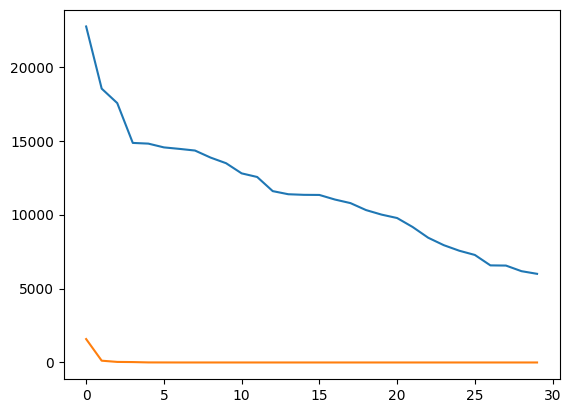

In [200]:
eigvals, _ = jlinops.eigsh(Q, k=30, which="LM", flip=True)
plt.plot(eigvals)
eigvals, _ = jlinops.eigsh(jlinops.aslinearoperator(Y), k=30, which="LM", flip=True)
plt.plot(eigvals)

In [156]:
largest_eigval, _ = jlinops.eigsh(H, k=1, which="LM")
print(largest_eigval)
smallest_eigval, _ = jlinops.eigsh(H, k=1, which="SM", maxiter=1000)
print(smallest_eigval)
h_condition_number = largest_eigval / smallest_eigval
print(f"Whitened posterior precision condition number: {h_condition_number}")

[1585.37890334]


ArpackNoConvergence: ARPACK error -1: No convergence (1001 iterations, 0/1 eigenvectors converged)